In [10]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments') ,
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    
    host='127.0.0.1',
    port=3307,  # Add this line
    user='root',
    password='Sanjana@02*',
    database='ecommerce'
)


cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:/Users/sanja/OneDrive/Desktop/Ecommerce"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect( 
    host='127.0.0.1',
    port=3307,  # Add this line
    user='root',
    password='Sanjana@02*',
    database='ecommerce')
cur =db.cursor()

# List all unique cities where customers are located.

In [46]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df =pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [29]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)  =2017 """

cur.execute(query)

data = cur.fetchall()


"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 135303)

#  Find the total sales per category.

In [34]:
query =""" select upper(products.product_category) category,
round(sum(payments.payment_value),2) Sales
from  products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id =order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df =pd.DataFrame(data,columns=["category","Sales"])
df

,category,Sales
0,PERFUMERY,13681943.82
1,FURNITURE DECORATION,38614762.58
2,TELEPHONY,13145815.37
3,BED TABLE BATH,46238949.12
4,AUTOMOTIVE,23011946.94
...,...,...
69,CDS MUSIC DVDS,32384.61
70,LA CUISINE,78665.31
71,FASHION CHILDREN'S CLOTHING,21213.09
72,PC GAMER,58709.61


# Calculate the percentage of orders that were paid in installments.

In [39]:
query = """select (sum(case when payment_installments>= 1 then 1 else 0 end))
/count(*)*100 from payments
"""
cur.execute(query)

data =cur.fetchall()

"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 

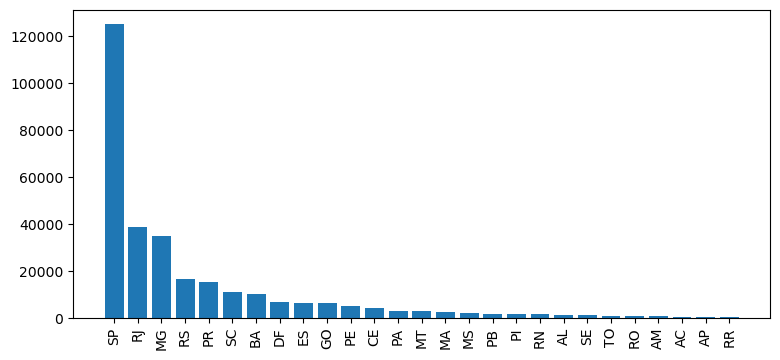

In [45]:
query =""" select  customer_state, count(customer_id)
from customers group by customer_state
"""
cur.execute(query)

data = cur.fetchall()
data
df =pd.DataFrame(data,columns=["state","customer_count"])
df = df.sort_values(by = "customer_count",ascending =False)
plt.figure(figsize=(9,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation =90)
plt.show()

# Calculate the number of orders per month in 2018.

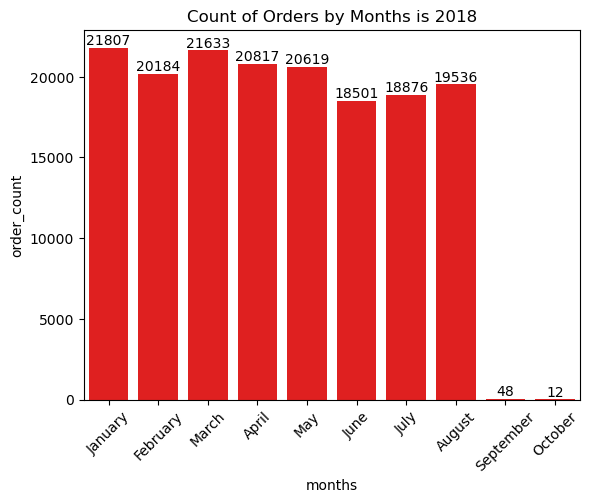

In [61]:
query =""" select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months"""

cur.execute(query)

data =cur.fetchall()
df =pd.DataFrame(data,columns =["months","order_count"])
o =["January","February","March","April","May","June","July","August","September","October"]
ax= sns.barplot(x=df["months"],y = df["order_count"],data = df,order=o,color="red")
plt.xticks(rotation =45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [72]:
query = """
    with count_per_order as (
        select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
        from orders
        join order_items
        on orders.order_id = order_items.order_id
        group by orders.order_id, orders.customer_id
    )
    select customers.customer_city, round(avg(count_per_order.oc), 2) as average_orders
    from customers
    join count_per_order
    on customers.customer_id = count_per_order.customer_id
    group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df =pd.DataFrame(data,columns =["customer city","average products/ order"])
df.head(10)


,customer city,average products/ order
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
5,cidelandia,36.00
6,curralinho,36.00
7,picarra,36.00
8,morro de sao paulo,36.00
9,teixeira soares,36.00


# Calculate the percentage of total revenue contributed by each product category.

In [74]:
query = """
    SELECT 
        UPPER(products.product_category) AS category,
        ROUND(SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments) * 100, 2) AS sales_percentage
    FROM 
        products 
    JOIN 
        order_items ON products.product_id = order_items.product_id
    JOIN 
        payments ON payments.order_id = order_items.order_id
    GROUP BY 
        category
    ORDER BY 
        sales_percentage DESC
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["category", "sales_percentage"])
df.head()

,category,sales_percentage
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35


# Identify the correlation between product price and the number of times a product has been purchased.

In [79]:
query ="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]
a =np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is",a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157556


# Calculate the total revenue generated by each seller, and rank them by revenue.

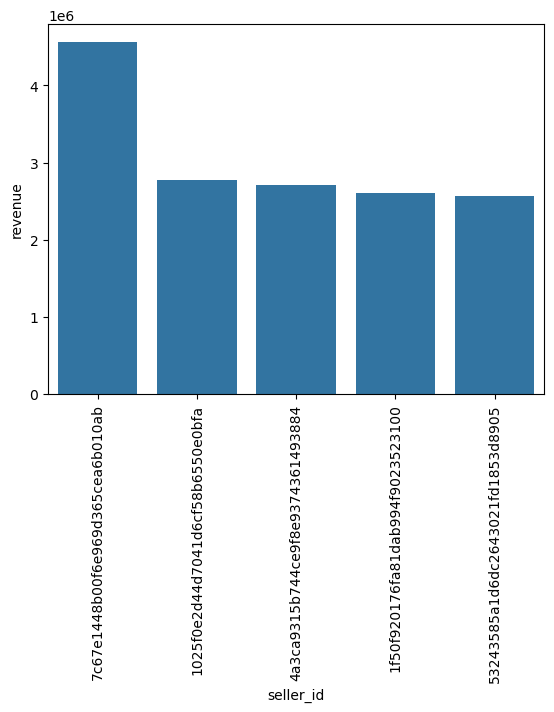

In [86]:
query = """
    SELECT *, DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
    FROM (
        SELECT order_items.seller_id, SUM(payments.payment_value) AS revenue
        FROM order_items
        JOIN payments ON order_items.order_id = payments.order_id
        GROUP BY order_items.seller_id
    ) AS a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x ="seller_id",y = "revenue",data =df)
plt.xticks(rotation =90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [88]:
query = """
    WITH orders_payments AS (
        SELECT 
            o.customer_id,
            o.order_purchase_timestamp,
            p.payment_value AS payment
        FROM 
            payments p
        JOIN 
            orders o ON p.order_id = o.order_id
    )
    SELECT 
        customer_id,
        order_purchase_timestamp,
        payment,
        AVG(payment) OVER (
            PARTITION BY customer_id 
            ORDER BY order_purchase_timestamp 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) AS mov_avg
    FROM 
        orders_payments
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [90]:
query = """
    WITH monthly_sales AS (
        SELECT 
            YEAR(o.order_purchase_timestamp) AS years,
            MONTH(o.order_purchase_timestamp) AS months,
            ROUND(SUM(p.payment_value), 2) AS payment
        FROM 
            orders o
        JOIN 
            payments p ON o.order_id = p.order_id
        GROUP BY 
            YEAR(o.order_purchase_timestamp),
            MONTH(o.order_purchase_timestamp)
    )
    SELECT 
        years,
        months,
        payment,
        SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
    FROM 
        monthly_sales
    ORDER BY 
        years, months
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2270.16,2.270160e+03
1,2016,10,531814.32,5.340845e+05
2,2016,12,176.58,5.342611e+05
3,2017,1,1246392.36,1.780653e+06
4,2017,2,2627172.09,4.407826e+06
5,2017,3,4048772.40,8.456598e+06
6,2017,4,3760092.27,1.221669e+07
7,2017,5,5336269.38,1.755296e+07
8,2017,6,4601487.42,2.215445e+07
9,2017,7,5331446.28,2.748589e+07


# Calculate the year-over-year growth rate of total sales.

In [95]:
query = """
    WITH a AS (
        SELECT 
            YEAR(o.order_purchase_timestamp) AS years,
            ROUND(SUM(p.payment_value), 2) AS payment
        FROM 
            orders o
        JOIN 
            payments p ON o.order_id = p.order_id
        GROUP BY 
            YEAR(o.order_purchase_timestamp)
    )
    Select years,((payment-lag(payment,1) over (order by years))/
    lag(payment,1) over(order by years))* 100 from a"""

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["years","you % growth"])
df

,years,you % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [98]:
query = """
    WITH a AS (
        SELECT 
            c.customer_id,
            MIN(o.order_purchase_timestamp) AS first_order
        FROM 
            customers c
        JOIN 
            orders o ON c.customer_id = o.customer_id
        GROUP BY 
            c.customer_id
    ),
    b AS (
        SELECT 
            a.customer_id,
            COUNT(DISTINCT o.order_id) AS repeat_orders
        FROM 
            a
        JOIN 
            orders o ON o.customer_id = a.customer_id
        WHERE 
            o.order_purchase_timestamp > a.first_order
            AND o.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
        GROUP BY 
            a.customer_id
    )
    SELECT 
        100 * (COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id)) AS repeat_purchase_rate
    FROM 
        a
    LEFT JOIN 
        b ON a.customer_id = b.customer_id
"""
cur.execute(query)
data =cur.fetchall()
data

[(Decimal('0.0000'),)]

# Identify the top 3 customers who spent the most money in each year.

In [104]:
query = """
    SELECT 
        years,
        customer_id,
        payment,
        d_rank
    FROM 
    (
        SELECT 
            YEAR(o.order_purchase_timestamp) AS years,
            o.customer_id,
            SUM(p.payment_value) AS payment,
            DENSE_RANK() OVER (
                PARTITION BY YEAR(o.order_purchase_timestamp)
                ORDER BY SUM(p.payment_value) DESC
            ) AS d_rank
        FROM 
            orders o
        JOIN 
            payments p ON p.order_id = o.order_id
        GROUP BY 
            YEAR(o.order_purchase_timestamp),
            o.customer_id
    ) AS a
    WHERE 
        d_rank <= 3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "customer_id", "payment", "rank"])

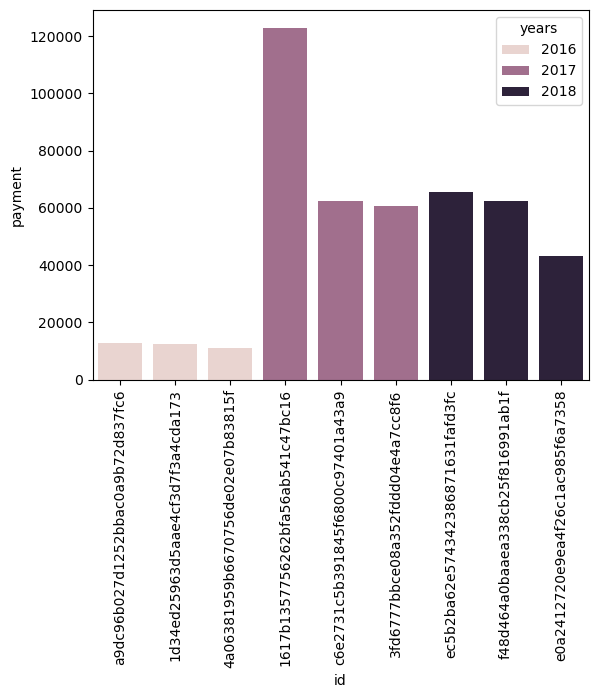

In [109]:
query = """
    SELECT 
        years,
        customer_id,
        payment,
        d_rank
    FROM 
    (
        SELECT 
            YEAR(o.order_purchase_timestamp) AS years,
            o.customer_id,
            SUM(p.payment_value) AS payment,
            DENSE_RANK() OVER (
                PARTITION BY YEAR(o.order_purchase_timestamp)
                ORDER BY SUM(p.payment_value) DESC
            ) AS d_rank
        FROM 
            orders o
        JOIN 
            payments p ON p.order_id = o.order_id
        GROUP BY 
            YEAR(o.order_purchase_timestamp),
            o.customer_id
    ) AS a
    WHERE 
        d_rank <= 3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])
sns.barplot(x="id",y ="payment",data =df,hue ="years")
plt.xticks(rotation=90)
plt.show()